In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable

import numpy as np
import cvxpy as cp

from free_flyer.free_flyer import FreeFlyer
import pickle, os

In [7]:
#load train/test data
prob = FreeFlyer() #use default config, pass different config file oth.
config_fn = './free_flyer/config/default.p'

config_file = open(config_fn,'rb')
dataset_name, _, _ = pickle.load(config_file); config_file.close()

relative_path = os.getcwd()
dataset_fn = relative_path + '/free_flyer/data/' + dataset_name

train_file = open(dataset_fn+'/train.p','rb')
# p_train, x_train, u_train, y_train, c_train, times_train = pickle.load(train_file)
train_data = pickle.load(train_file)
train_file.close()
x_train = train_data[1]
y_train = train_data[3]

test_file = open(dataset_fn+'/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test, c_test, times_test = test_data
test_file.close()

n_test = x_test.shape[0]

# naive MLOPT classifier

In [17]:
from solvers.mlopt import MLOPT

system = 'free_flyer'
prob_features = ['x0', 'obstacles']
mlopt_obj = MLOPT(system, prob, prob_features)

n_features = 36
mlopt_obj.construct_strategies(n_features, train_data)
print(mlopt_obj.n_strategies)

67217


In [18]:
mlopt_obj.setup_network()

fn_saved = 'mlopt_free_flyer_20200707_1425.pt'
fn_saved = 'None'
mlopt_obj.load_network(fn_saved)

mlopt_obj.model

FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=36, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=67217, bias=True)
  )
)

In [ ]:
mlopt_obj.training_params['TRAINING_ITERATIONS'] = 500
mlopt_obj.train(verbose=False)
print(mlopt_obj.model_fn)

In [ ]:
n_succ = 0
count = 0

costs_naive_mlopt = []
total_time_naive_mlopt = []
num_solves_naive_mlopt = []

cost_ratios_naive_mlopt = []

for ii in range(n_test):
    if ii % 1000 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals, optvals = mlopt_obj.forward(prob_params)

        count += 1
        if prob_success:
            n_succ += 1
            costs_naive_mlopt += [cost]
            total_time_naive_mlopt += [total_time]
            num_solves_naive_mlopt += [n_evals]

            true_cost = c_test[ii]
            cost_ratios_naive_mlopt += [cost / true_cost]
    except:
        continue

costs_naive_mlopt = np.array(costs_naive_mlopt)
cost_ratios_naive_mlopt = np.array(cost_ratios_naive_mlopt)
total_time_naive_mlopt = np.array(total_time_naive_mlopt)
num_solves_naive_mlopt = np.array(num_solves_naive_mlopt, dtype=int)

mlopt_naive_percentage = 100 * float(n_succ) / float(count)
mlopt_naive_percentage

0 / 10000


In [ ]:
idx = np.random.randint(train_data[1].shape[0])
x0 = train_data[0]['x0'][idx]
n_obs = train_data[0]['obstacles'][idx].shape[1]
posmin, posmax = mlopt_obj.problem.posmin, mlopt_obj.problem.posmax

obstacles = []
for ii_obs in range(n_obs):
    obs = train_data[0]['obstacles'][idx][:,ii_obs]
    obstacles.append(obs)

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
    plt.gca().add_patch(circle)    

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

# task-specific MLOPT

In [3]:
from solvers.mlopt_ff import MLOPT_FF

In [9]:
system = 'free_flyer'
prob_features = ['x0', 'obstacles']
mlopt_ts_obj = MLOPT_FF(system, prob, prob_features)

n_features = 4 + 4*prob.n_obs + prob.n_obs
mlopt_ts_obj.construct_strategies(n_features, train_data)
print(mlopt_ts_obj.n_strategies)

458


In [11]:
mlopt_ts_obj.setup_network()

fn_saved = 'models/mloptff_free_flyer_20200702_1648.pt' # for data_files
fn_saved = 'models/mloptff_free_flyer_20200715_1631.pt'        # new spaced apart data
mlopt_ts_obj.load_network(fn_saved)

mlopt_ts_obj.model

FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=44, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=458, bias=True)
  )
)

In [ ]:
mlopt_ts_obj.training_params['TRAINING_ITERATIONS'] = 500
mlopt_ts_obj.train(verbose=True)
print(mlopt_ts_obj.model_fn)

loss:   2.621804714202881,   acc:  0.4375
loss:   2.459498643875122,   acc:  0.34375
loss:   2.2616827487945557,   acc:  0.4375
loss:   2.2433159351348877,   acc:  0.5
loss:   1.9593143463134766,   acc:  0.53125
loss:   1.5043317079544067,   acc:  0.59375
loss:   1.5069977045059204,   acc:  0.53125
loss:   1.6051725149154663,   acc:  0.5
loss:   1.4941112995147705,   acc:  0.59375
loss:   1.7854900360107422,   acc:  0.5
loss:   2.090888261795044,   acc:  0.46875
Done with epoch 0 in 24.229624032974243s
loss:   1.9242688417434692,   acc:  0.4375
loss:   1.4038749933242798,   acc:  0.4375
loss:   1.2796796560287476,   acc:  0.53125
loss:   1.573239803314209,   acc:  0.4375
loss:   1.7382869720458984,   acc:  0.46875
loss:   1.3915371894836426,   acc:  0.59375
loss:   1.4845337867736816,   acc:  0.59375
loss:   1.5259040594100952,   acc:  0.5
loss:   1.2398004531860352,   acc:  0.625
loss:   1.55765700340271,   acc:  0.625
loss:   1.7207660675048828,   acc:  0.4375
Done with epoch 1 in 24

In [ ]:
n_succ = 0
count = 0
gurobi_mlopt_fail = 0

costs_mlopt = []
total_time_mlopt = []
num_solves_mlopt = []

cost_ratios_mlopt = []
costs_ip = []
total_time_ip = []
num_solves_ip = []

for ii in range(n_test):
    if ii % 1000 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals, optvals = mlopt_ts_obj.forward(prob_params)

        count += 1
        if prob_success:
            n_succ += 1
            costs_mlopt += [cost]
            total_time_mlopt += [total_time]
            num_solves_mlopt += [n_evals]

            true_cost = c_test[ii]
            costs_ip += [true_cost]
            total_time_ip += [times_test[ii]]

            cost_ratios_mlopt += [cost / true_cost]
    except:
        print('Solver failed at {}'.format(ii))
        gurobi_mlopt_fail += 1
        continue

costs_mlopt = np.array(costs_mlopt)
cost_ratios_mlopt = np.array(cost_ratios_mlopt)
total_time_mlopt = np.array(total_time_mlopt)
num_solves_mlopt = np.array(num_solves_mlopt, dtype=int)

costs_ip = np.array(costs_ip)
total_time_ip = np.array(total_time_ip)
num_solves_ip = np.array(num_solves_ip, dtype=int)

mlopt_percentage = 100 * float(n_succ) / float(count)
mlopt_percentage

0 / 10000


In [16]:
mlopt_percentage

98.18945683705111

# test Regression solver

In [8]:
from solvers.regression import Regression

system = 'free_flyer'
prob_features = ['x0', 'obstacles']
reg_obj = Regression(system, prob, prob_features)

n_features = 36
reg_obj.construct_strategies(n_features, train_data)

In [9]:
reg_obj.setup_network()

fn_saved = 'models/regression_free_flyer_20200708_0809.pt'
reg_obj.load_network(fn_saved)

reg_obj.model

Loading presaved regression model from models/regression_free_flyer_20200708_0809.pt


FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=36, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=160, bias=True)
  )
)

In [ ]:
mlopt_obj.training_params['TRAINING_ITERATIONS'] = 500
reg_obj.train(verbose=False)
print(reg_obj.model_fn)

In [ ]:
n_succ = 0
count = 0

costs_reg = []
total_time_reg = []
num_solves_reg = []

cost_ratios_reg = []

for ii in range(n_test):
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, optvals = reg_obj.forward(prob_params)

        count += 1
        if prob_success:
            n_succ += 1
            costs_reg += [cost]
            total_time_reg += [total_time]
            num_solves_reg += [1]

            true_cost = c_test[ii]
            cost_ratios_reg += [cost / true_cost]
    except:
        continue

costs_reg = np.array(costs_reg)
cost_ratios_reg = np.array(cost_ratios_reg)
total_time_reg = np.array(total_time_reg)
num_solves_reg = np.array(num_solves_reg, dtype=int)

reg_percentage = 100 * float(n_succ) / float(count)
reg_percentage

# Results

In [24]:
import math
import seaborn as sns
sns.set(font_scale=1.5, font="serif", style="whitegrid")
import pandas as pd

flierprops = {'alpha':0.2}

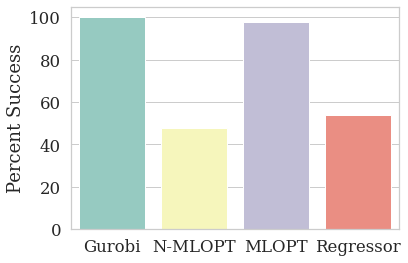

In [25]:
results = {'Gurobi':[100.], 'N-MLOPT':[mlopt_naive_percentage], 'MLOPT':[mlopt_percentage], 'Regressor':[reg_percentage]}
results = pd.DataFrame(results)

ax1 = sns.barplot(data=results, palette="Set3", label='small')
ax1.set(xlabel="", ylabel="Percent Success")

plt.tight_layout()

figure = ax1.get_figure()
# # figure.savefig("loss.pdf")

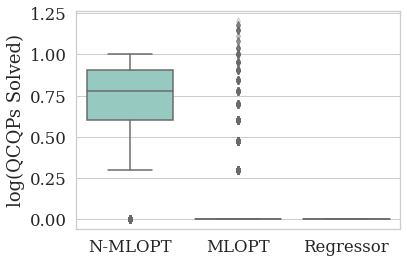

In [26]:
results = {}
results['Policy'] = ['N-MLOPT']*len(num_solves_naive_mlopt) + \
    ['MLOPT']*len(num_solves_mlopt) + ['Regressor']*len(num_solves_reg)
results['Solves'] = np.hstack((np.log10(num_solves_naive_mlopt), \
    np.log10(num_solves_mlopt), np.log10(num_solves_reg)))
results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Solves'], palette="Set3", flierprops=flierprops)                            
ax1.set(xlabel="", ylabel="log(QCQPs Solved)")

plt.tight_layout()

figure = ax1.get_figure()
# figure.savefig("loss.pdf")

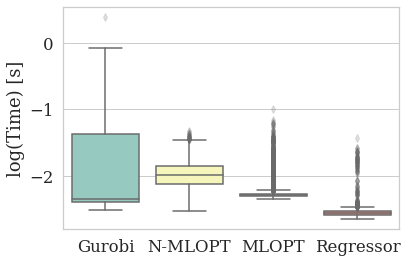

In [27]:
results = {}
results['Policy'] = ['Gurobi']*len(total_time_ip) + \
    ['N-MLOPT']*len(total_time_naive_mlopt) + ['MLOPT']*len(total_time_mlopt) + \
    ['Regressor']*len(total_time_reg)
results['Time'] = np.hstack((np.log10(total_time_ip), \
    np.log10(total_time_naive_mlopt), np.log10(total_time_mlopt), \
    np.log10(total_time_reg)))
results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Time'], palette="Set3", flierprops=flierprops)
ax1.set(xlabel="", ylabel="log(Time) [s]")

plt.tight_layout()

figure = ax1.get_figure()
# figure.savefig("loss.pdf")

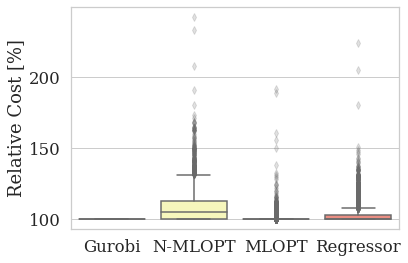

In [28]:
results = {}
results['Policy'] = ['Gurobi']*len(costs_ip) + \
    ['N-MLOPT']*len(cost_ratios_naive_mlopt) + ['MLOPT']*len(cost_ratios_mlopt) +\
    ['Regressor']*len(cost_ratios_reg)
results['Costs'] = np.hstack((100*np.ones(len(costs_ip)), \
    100*cost_ratios_naive_mlopt, 100*cost_ratios_mlopt, 100*cost_ratios_reg))
results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Costs'], palette="Set3", flierprops=flierprops)
ax1.set(xlabel="", ylabel="Relative Cost [%]")

plt.tight_layout()
# plt.ylim(0, int(math.ceil(np.max(np.maximum(costs_ip, costs_naive_mlopt, costs_mlopt)) / 10.0)) * 10)

figure = ax1.get_figure()
# figure.savefig("loss.pdf")